In [67]:
#Hidden Markov Model inference and learning

In [68]:
#Casino Problem
#We have a sequence of observations (1,2,3,4,5,6) which correspond to underlying states (Fair vs Biased die)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# Obs States: T, H = (0,1)
# Underlying States: F, B = (0, 1)
# Observation model p(x|z) => 
# Transition model p(z_{t} | z_{t-1}) => p(F | B) = .05, p(B | F) = .1, p(B | B) = .95, p(F | F) = .9
#

#Casino Problem
obs_model = np.array([ 1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 1/10,1/10,1/10,1/10,1/10,5/10 ]).reshape((2,-1))
trans_model = np.array([[.95, .01], [.05, .99]])
pi = [.5,.5]

#Start with (State, Obs) pair (F,D) = (0,1)
states = [np.array([0,1])]
len_seq = 300
for i in range(len_seq):
    current_state = states[-1]
    z = current_state[0]
    x = current_state[1]
    
    z_t1_probs = trans_model[:,z]
    z_t1 = np.random.choice([0,1],1,p=z_t1_probs)[0]

    x_t1_probs = obs_model[z_t1]
    x_t1 = np.random.choice(np.arange(obs_model.shape[1]),1,p=x_t1_probs)[0]
    
    states.append(np.array([z_t1,x_t1]))
    
states = np.array(states)

In [71]:
#states = np.array([[0,0], [0,2], [0,2], [0,1], [0,2], [0,3]])
states[:10]

array([[0, 1],
       [0, 3],
       [0, 2],
       [0, 0],
       [0, 5],
       [0, 3],
       [0, 4],
       [0, 4],
       [1, 5],
       [1, 1]])

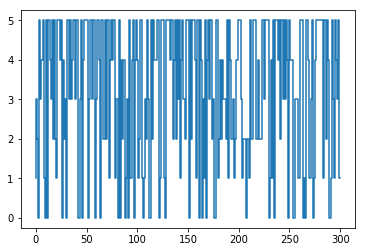

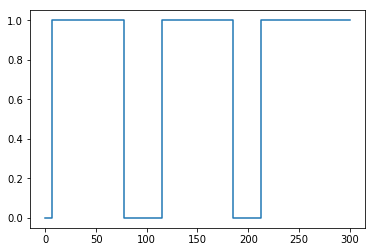

In [72]:
plt.plot(np.arange(len(states)),states[:,1],drawstyle='steps-pre')
plt.show()
plt.plot(np.arange(len(states)),states[:,0],drawstyle='steps-pre')
plt.show()

In [73]:
#Forwards algorithm
#We want to compute p(z_t | x_1:t) propto p(z_t | z_t-1)

#beliefs are for z_t = {0,1}
#beliefs = [np.array([0,1])]
#beliefs = [obs_model[states[0][1]] * [.5, .5]]
beliefs = [np.array([1,1])]

for current_time in range(states.shape[0]):
    pred_density = np.dot(trans_model.T, beliefs[-1])
    current_state = states[current_time]
    #print(pred_density, current_state[1])
    new_belief = obs_model[:,current_state[1]] * pred_density
    
    if current_time == 0:
        new_belief = new_belief * pi
    new_belief = new_belief/sum(new_belief)
    beliefs.append(new_belief)
    
beliefs = np.array(beliefs)[1:]

In [74]:
np.set_printoptions(suppress=True)
beliefs[:10]

array([[0.625     , 0.375     ],
       [0.73003576, 0.26996424],
       [0.81102956, 0.18897044],
       [0.86944344, 0.13055656],
       [0.66795752, 0.33204248],
       [0.76391327, 0.23608673],
       [0.83586957, 0.16413043],
       [0.8867046 , 0.1132954 ],
       [0.70020503, 0.29979497],
       [0.78865268, 0.21134732]])

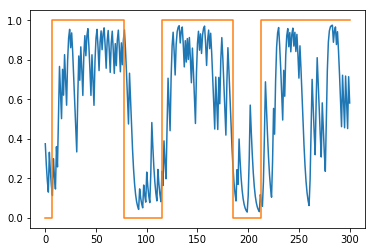

In [76]:
plt.plot(np.arange(len(beliefs)),beliefs[:,1])
#plt.show()
plt.plot(np.arange(len(states)),states[:,0],drawstyle='steps-pre')
plt.show()

In [77]:
sum((beliefs[:,1] > .5) == states[:,0])/len_seq

0.8133333333333334

In [78]:
### Forward Backward for smoothing
#Key idea is to break into past & future
#p(z_t | x_1:T) propto p(z_t = j | x_1:t) * p(x_{t+1}:T | z_t = j)
#The first term is our belief state at time t, the second is our
#conditional likelihood of future evidence given hidden state.

conditional_likelihoods = [np.array([1,1])]

beliefs = [np.array([1,1])]

for current_time in range(states.shape[0]):
    pred_density = np.dot(trans_model.T, beliefs[-1])
    current_state = states[current_time]
    #print(pred_density, current_state[1])
    new_belief = obs_model[:,current_state[1]] * pred_density
    
    if current_time == 0:
        new_belief = new_belief * pi
    #new_belief = new_belief/sum(new_belief)
    beliefs.append(new_belief)
    
beliefs = np.array(beliefs)

#calculate conditional likelihood (right->left)
for current_time in reversed(range(states.shape[0])):
    #get beta_t
    current_conditional_likelihood = conditional_likelihoods[-1]
    current_state = states[current_time]
    past_conditional_likelihood = np.dot(trans_model,obs_model[:,current_state[1]] * current_conditional_likelihood)
    #past_conditional_likelihood = past_conditional_likelihood/ np.sum(past_conditional_likelihood)
    conditional_likelihoods.append(past_conditional_likelihood)

conditional_likelihoods = np.array(list(reversed(conditional_likelihoods)))

gamma = conditional_likelihoods * beliefs
gamma = gamma / np.sum(gamma,axis=1)[:,None]
gamma = gamma[1:]

In [79]:
conditional_likelihoods[:10]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [80]:
gamma[:10]

array([[0.37013933, 0.62986067],
       [0.37108666, 0.62891334],
       [0.36098783, 0.63901217],
       [0.33755207, 0.66244793],
       [0.29546328, 0.70453672],
       [0.28865639, 0.71134361],
       [0.26986723, 0.73013277],
       [0.23483373, 0.76516627],
       [0.17560899, 0.82439101],
       [0.15976382, 0.84023618]])

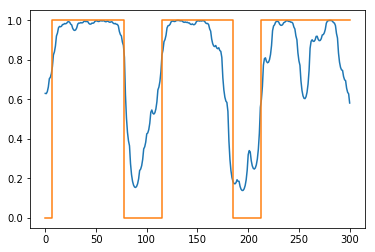

In [81]:
plt.plot(np.arange(len(gamma)),gamma[:,1])
#plt.show()
plt.plot(np.arange(len(states)),states[:,0],drawstyle='steps-pre')
plt.show()

In [83]:
sum((gamma[:,1] > .5) == states[:,0])/len_seq

0.9066666666666666

In [84]:
#Viterbi Algorithm to find the most likely path
#We want delta_t(j) = max_{z_1 .. z_t} p(z_1:t-1, z_t = j | x_1:t)

num_states = 2
T1 = np.zeros((num_states, states.shape[0]))
T2 = np.zeros((num_states, states.shape[0]))

for i in range(num_states):
    T1[i,0] = pi[i] * obs_model[i,states[0][1]]
    T2[i,0] = 0
    
for i in range(1,states.shape[0]):
    for j in range(num_states):
        T1[j,i] = np.max(T1[:,i-1] * trans_model[:,j] * obs_model[j,states[i][1]])
        T2[j,i] = np.argmax(T1[:,i-1] * trans_model[:,j] * obs_model[j,states[i][1]] )
        
z = np.zeros((states.shape[0]),dtype=np.int32)
z[-1] = np.argmax(T1[:,-1])
x = np.zeros((states.shape[0]),dtype=np.int32)
x[-1] = z[-1]

for i in range(states.shape[0]-1,0,-1):
    z[i-1] = T2[z[i],i]
    x[i-1] = z[i-1]
    
#return x

In [85]:
x

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [86]:
sum(x == states[:,0])/len_seq

0.76